In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf


# Preparing the dataset


In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

2022-03-04 19:07:31.618587: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model_name = "BERT_tokenizer_ru_en"

tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"file://Users/camilla/code/chatbot2/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

tokenizers = tf.saved_model.load("BERT_tokenizer_ru_en")

[item for item in dir(tokenizers.ru) if not item.startswith('_')]


['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [5]:
for ru_examples, en_examples in train_examples.batch(3).take(1):
  for ru in ru_examples.numpy():
    print(ru.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

for en in en_examples.numpy():
  print(en.decode('utf-8'))

encoded = tokenizers.en.tokenize(en_examples)
print()

for row in encoded.to_list():
  print(row)

print() 

round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))


к : успех , перемены возможны только с оружием в руках .
документация и методика практического обучения также доступна и выпущена creative commons .
( видео ) диди пиклз : сейчас четыре часа утра .

c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .
c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


2022-03-04 19:07:34.101877: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



[2, 43, 28, 59, 6508, 2211, 5051, 539, 539, 14, 3269, 43, 6115, 4341, 2946, 649, 49, 539, 55, 2369, 1461, 1215, 4858, 3493, 60, 6115, 1545, 832, 6508, 2946, 6115, 3269, 42, 3810, 5947, 1461, 55, 4342, 3269, 47, 6508, 2369, 16, 3]
[2, 3269, 44, 832, 2211, 6508, 7013, 2369, 830, 770, 5876, 41, 2369, 748, 3269, 48, 4341, 748, 539, 15, 55, 2369, 60, 649, 770, 4720, 3493, 53, 5511, 6115, 832, 748, 832, 1461, 832, 2946, 1215, 49, 539, 41, 1461, 539, 832, 55, 1994, 7012, 15, 59, 832, 6508, 1545, 5051, 41, 2369, 748, 58, 649, 3381, 770, 7477, 748, 41, 539, 3269, 43, 5947, 770, 830, 969, 4343, 4858, 1671, 3028, 539, 16, 3]
[2, 10, 62, 969, 748, 649, 832, 11, 44, 969, 748, 969, 56, 4986, 2091, 3381, 539, 28, 49, 830, 9, 59, 46, 832, 6508, 1545, 55, 9, 43, 1461, 832, 6299, 49, 2369, 3269, 53, 7476, 2369, 3493, 16, 3]

c : success , the change is only coming through the barrel of the gun .
the documentation and the hands - on teaching methodology is also open - source and released as the creative

# Input Pipeline

Some transformations has to be done to the dataset in order to make it suitable for training.

In [6]:
def tokenize_pairs(ru, en):
    ru = tokenizers.ru.tokenize(ru)
    # Convert from ragged to dense, padding with zeros.
    ru = ru.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()

    return ru, en

In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [8]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)



# Positional encoding

Positional encoding is needed to give the model information about the relative positions of the tokens in the sentence, as we don't have any recurrent or convolutional layers.

This encoding is added to the embedding vector, which represents a token in a d-dimensional space. Tokens with similar meaning will be closer to each other. 

After adding the positional encoding, tokens will be closer to each other based on the similarity of their meaning and their position in the sentence.

In [9]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model)) 
  return pos * angle_rates

In [10]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
                          
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


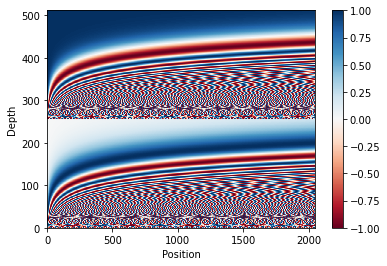

In [11]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Masking

We need to mask all the pad-tokens, which ensures that the model does not treat padding as input.

This mask will indicate padding by outputting 1 on those locations and 0 everywhere else.


In [12]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [13]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

## Look-ahead mask

We need to be able to mask the future tokens in a sentence, so our model cannot peek. The look-ahead mask indicates which entries should not be used.


In [14]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0) #lower triangular part
  return mask  # (seq_len, seq_len)

In [15]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# Attention is all you need

## Scaled dot-product attention

This attention function is to be used in the Multi-Head attention layer.
Information about the scaled dot-product attention formula can be found in the paper "Attention is all you need": https://arxiv.org/abs/1706.03762

In [16]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

# Multi-head attention

The multi-head attention layer consists of:
- Linear layers
- Scaled dot product attention
- Final linear layer

Each multi-head attention block gets the inputs Q,V and K. These are put through the linear (DENSE) layers before the attention function. 

Note: the attention output is for each attention head is concatinated using tf.transpose and tc.reshape and put through a final dense layer.


In [17]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [18]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

# Point-wise feed forward network

This part consists of teo fully-connected (dense) layers with ReLU activation in between.

In [19]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [20]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

# Encoder and Decoder

The input sequence is passed through N encoder layers that generates an output token in the sentence. The decoder attends to ethe encoder output and its own input (self-attention) to predict the next word.

### Encoder layer

Each encoder layer consists of 1) multi-head attention with padding mask and 2) point wise feed forward networks.

Each of these layers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing fradient problem in deep networks.

Residual connection provides another path for data to reach latter parts of the neural network by skipping some layers.

The dropout layer randomly sets input units to 0 with a freequency rate at each step during training time, which helps prevent overfitting.

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [22]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder consists of sublayers:
- Masked multi-head attention (with look ahead mask AND padding mask)
- Multi-head attention (with padding mask). V and K recieve the encoder output as inputs, Q recieve the output from the masked multi-head-attention layer
- Point-wise feed forward networks
- Each of these sublayers have residual connections around it, followed by normalization

As Q recieves the output from the decoders first attention block, and K recieves the encoder output, the attention weights represent the importance given to the decoder input based on the encoders output.

In other words: the decoder predicts the next token by looking at the encoder output and self-attending its own output.

In [23]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [24]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

# Encoder

Now to put the encoder together, it consists of;
- Input embedding
- Positional encoding
- N encoder layers (implemented above)

The input is put through embedding, which is summed up with the encoding. The output from this is the input to the encoder layers. The output of the endoder is the input to the encoder.

In [25]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    # embedding: Turns positive integers (indexes) into dense vectors of fixed size.
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) #??
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [26]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


# Decoder

The decoder consists of:
- Output embedding
- Positional encoding
- N decoder layers

The target data is put through an embedding layer which is summed up with the positional encoding. The output from this summation is then input to the final linear layer.


In [27]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=True)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [28]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# Creating the Transformer

The transformer consists of the encoder, decoder and the final linear layer. The output from the decoder is used as input to the linear layer and its output is returned

In [29]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [30]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

# Getting ready for training

To keep this small and fast, the values for num_layers and dff (inner layer dimensionality) have been reduced from those used in the paper "Attention is all you need"

### Optimizer

The Adam optimizer with a custom learning rate is used, according to the formula in the paper. The learning rate is linear for the warmup steps then is decreased proportionally to the inverse square root of the step number

In [31]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [32]:
# Optimizer

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [33]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

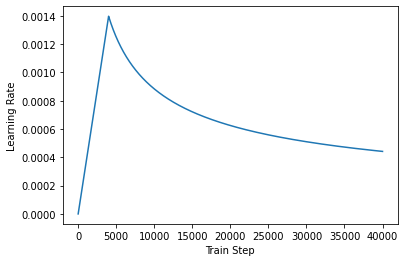

In [34]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Loss and metrics

Since the target sequence is padded, we must also add padding mask when calculating the loss

In [35]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [36]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask) #Computes the sum of elements across dimensions of a tensor.


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [37]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

# Training and checkpointing

In [38]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.ru.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [39]:
checkpoint_path = "./checkpoints_ru/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Latest checkpoint restored!!


The target is divided into tar_input and tar_real. Tar inpt is passed as input to the decoder. Tar_real is that same input, SHIFTED by one. This is so that every location in tar_input and tar_real contains the next token that should be predicted.

- The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

- During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

- As the transformer predicts each token, self-attention allows it to look at the previous tokens in the input sequence to better predict the next token.



In [40]:
EPOCHS = 20

In [41]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


#Compiles a function into a callable TensorFlow graph.
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:] #shifted by 1

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [374]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')


  ckpt_save_path = ckpt_manager.save()
  print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')


  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

# Inference



In [42]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=60):
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.ru.tokenize(sentence).to_tensor() #should it be tokenixe==

    encoder_input = sentence

    # as the target is english, the first token to the transformer should be the
    # english start token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start) #index, value

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)

    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]
    
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

In [43]:
translator = Translator(tokenizers, transformer)

def print_interaction(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [44]:
sentence = "вы когда-нибудь шли из одной комнату в другую , а потом не могли вспомнить зачем ?"
ground_truth = "have you ever walked from one room to another and then forgotten why you 're there ?"

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))

print_interaction(sentence, translated_text, ground_truth)

translated_text = translator(tf.constant(sentence))


Input:         : вы когда-нибудь шли из одной комнату в другую , а потом не могли вспомнить зачем ?
Prediction     : did you ever walk on one room , and then then , why was n ' t the other room ?
Ground truth   : have you ever walked from one room to another and then forgotten why you 're there ?


In [50]:
class ExportTranslator(tf.Module):
  def __init__(self, chatbot):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result, 
     tokens,
     attention_weights) = self.translator(sentence, max_length=100)

    return result

In [51]:
translator = ExportTranslator(translator)

In [ ]:
tf.saved_model.save(translator, export_dir='ru_en_translator')


In [53]:
reloaded = tf.saved_model.load('ru_en_translator')

In [54]:
word = "вы когда-нибудь шли из одной комнату в другую , а потом не могли вспомнить зачем ?"

translated_text= reloaded(tf.constant(word))
print(translated_text)

tf.Tensor(b"did you ever walk on one room , and then then , why would n ' t imagine why ?", shape=(), dtype=string)


# Attention plots

In [55]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [56]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([49, 20])

In [57]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.ru.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.ru.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(20,), dtype=string, numpy=
array([b'[START]', b'\xd0\xb2\xd1\x8b',
       b'\xd0\xba\xd0\xbe\xd0\xb3\xd0\xb4\xd0\xb0', b'-',
       b'\xd0\xbd\xd0\xb8\xd0\xb1\xd1\x83\xd0\xb4\xd1\x8c',
       b'\xd1\x88\xd0\xbb\xd0\xb8', b'\xd0\xb8\xd0\xb7',
       b'\xd0\xbe\xd0\xb4\xd0\xbd\xd0\xbe\xd0\xb8',
       b'\xd0\xba\xd0\xbe\xd0\xbc\xd0\xbd\xd0\xb0\xd1\x82\xd1\x83',
       b'\xd0\xb2', b'\xd0\xb4\xd1\x80\xd1\x83\xd0\xb3\xd1\x83\xd1\x8e',
       b',', b'\xd0\xb0', b'\xd0\xbf\xd0\xbe\xd1\x82\xd0\xbe\xd0\xbc',
       b'\xd0\xbd\xd0\xb5', b'\xd0\xbc\xd0\xbe\xd0\xb3\xd0\xbb\xd0\xb8',
       b'\xd0\xb2\xd1\x81\xd0\xbf\xd0\xbe\xd0\xbc\xd0\xbd\xd0\xb8\xd1\x82\xd1\x8c',
       b'\xd0\xb7\xd0\xb0\xd1\x87\xd0\xb5\xd0\xbc', b'?', b'[END]'],
      dtype=object)>

In [58]:
translated_tokens


<tf.Tensor: shape=(50,), dtype=string, numpy=
array([b'[START]', b'd', b'##i', b'##d', b'y', b'##o', b'##u', b'e',
       b'##ve', b'##r', b'w', b'##al', b'##k', b'o', b'##n', b'o', b'##n',
       b'##e', b'r', b'##o', b'##o', b'##m', b',', b'a', b'##n', b'##d',
       b'the', b'##n', b'the', b'##n', b',', b'w', b'##h', b'##y', b'w',
       b'##a', b'##s', b'n', b"'", b't', b'the', b'o', b'##th', b'##er',
       b'r', b'##o', b'##o', b'##m', b'?', b'[END]'], dtype=object)>

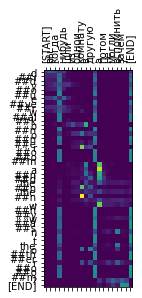

In [59]:
plot_attention_head(in_tokens, translated_tokens, attention)


In [60]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.ru.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.ru.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

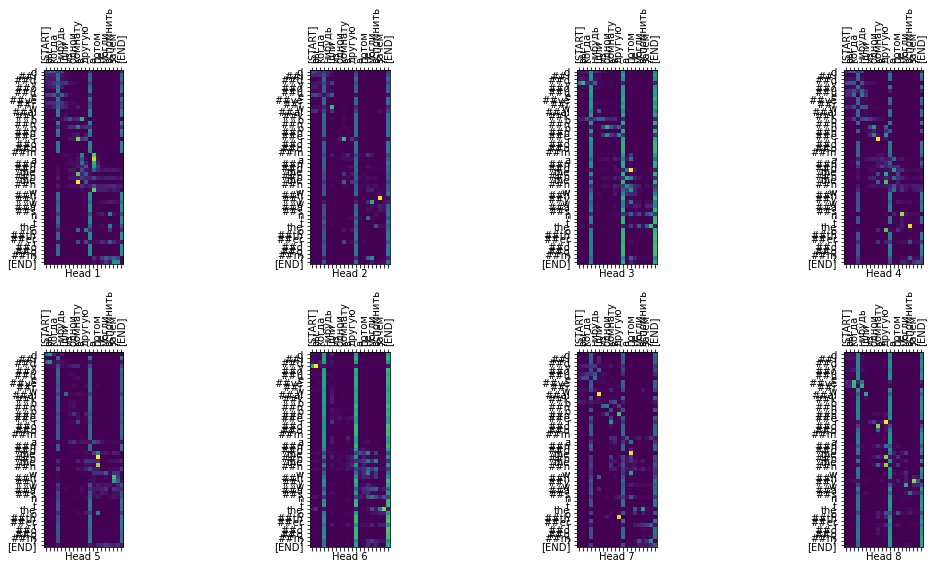

In [61]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])


In [ ]:
sentence = "( видео ) сейчас четыре часа утра?"
ground_truth = "( video ) : it 's four o'clock in the morning"

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))

print_interaction(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

# Evaluating the results 

In order to evaluate the results, the BLEU-metrics is used. This was not done in the tensorflow-tutorial. 

In [69]:
from nltk.translate.bleu_score import sentence_bleu

n_test_examples = 1588

test_examples = examples['test']
test_batches = make_batches(test_examples)
bleu = 0

for ru, en in test_examples:
  prediction = reloaded(ru.numpy().decode('utf-8'))
  prediction = prediction.numpy().decode('utf-8').split()
  sentence_blue = sentence_bleu([en.numpy().decode('utf-8').split()], prediction)
  bleu += sentence_blue

BLEU = bleu/n_test_examples
print(BLEU)

0.1466322034197209
